# XENETA OCEANS FREIGHT RATES DATA WRANGLING
Project to clean data for freight rates

In [57]:
#import necessary libraries and packges

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import sqlite3
from tqdm import tqdm
from typing import List

In [58]:
#Load data
data = pd.read_excel(r"C:\Users\Sammy\Downloads\test\test\data_science_test_1.xlsx", sheet_name=['Ocean Freight Rates','Lookups','Final Import'])
OFR_data = data['Ocean Freight Rates']
final_output = data['Final Import']

In [59]:
OFR_data.shape

(16660, 15)

In [60]:

xeneta = OFR_data.loc[5:] # Select the portion of the dataset containing the main freight rates data 
xeneta.columns = xeneta.iloc[0] # set column names to the values in the 5th row
xeneta.drop(5, inplace=True) #drop the row
xeneta = xeneta.reset_index(drop=True) #reset the index to start from 0


In [61]:
""" Dropping each row where the value for Rate Basis column = PER_DOC' because it is not included"""

xeneta = xeneta[xeneta['Rate Basis'] != 'PER_DOC']
xeneta.head()

5,Receipt,Load Port,Discharge Port,Delivery,Effective Date,Expiry Date,Service Mode,Commodity Name,Inclusive Surcharges,Charge,Rate Basis,20DRY,40DRY,40HDRY,45HDRY
0,"Anqing, China",NaN,NaN,"Cochin, India",29-Apr-2011,12-May-2011,CY/CY,FAK,"DPA,OPA,SBF,BAF",BAS,PER_CONTAINER,760 USD,1010 USD,1010 USD,1310 USD
1,"Anqing, China",NaN,NaN,"Cochin, India",29-Apr-2011,12-May-2011,CY/CY,FAK,"DPA,OPA,SBF,BAF",CFD,PER_CONTAINER,0 USD,0 USD,0 USD,0 USD
2,"Anqing, China",NaN,NaN,"Cochin, India",29-Apr-2011,12-May-2011,CY/CY,FAK,"DPA,OPA,SBF,BAF",CFO,PER_CONTAINER,0 USD,0 USD,0 USD,0 USD
4,"Anqing, China",NaN,NaN,"Cochin, India",29-Apr-2011,12-May-2011,CY/CY,FAK,"DPA,OPA,SBF,BAF",DHC,PER_CONTAINER,10175 INR,13500 INR,13500 INR,17900 INR
5,"Anqing, China",NaN,NaN,"Cochin, India",29-Apr-2011,12-May-2011,CY/CY,FAK,"DPA,OPA,SBF,BAF",ERS,PER_CONTAINER,0 USD,0 USD,0 USD,0 USD


In [62]:
"""renaming the equipment types and other column to match the expected output file"""

xeneta.rename(columns={'20DRY': '20DC', '40DRY': '40DC','40HDRY':'40HC','Effective Date': 'Rate - Valid from', 'Expiry Date': 'Rate - Valid to','Receipt':'Origin Port (name)','Delivery':'Destination Port (name)','Inclusive Surcharges':'THC Used','Commodity Name':'Commodity'}, inplace=True)	 		

### WRANGLING THE DATAFRAME TO GET IT IN THE DESIRED FORMAT

Create a pivot the 'Charge' column using the '20DC','40DC','40HC' columns as values to fill it up. The pivot function makes the charges column horizontal. This allows the values for each surcharge be represented by a column.

In [63]:
xeneta_charges_pivot = xeneta.pivot(columns= 'Charge' ,values= ['20DC','40DC','40HC']) # call the pivot function 
xeneta_charges_pivot.head()

20DC                                                          ...   \
Charge      BAS    CFD    CFO        DHC  EBS    ERS  EXP  IMP  LSS  OHC ...    
0       760 USD    NaN    NaN        NaN  NaN    NaN  NaN  NaN  NaN  NaN ...    
1           NaN  0 USD    NaN        NaN  NaN    NaN  NaN  NaN  NaN  NaN ...    
2           NaN    NaN  0 USD        NaN  NaN    NaN  NaN  NaN  NaN  NaN ...    
4           NaN    NaN    NaN  10175 INR  NaN    NaN  NaN  NaN  NaN  NaN ...    
5           NaN    NaN    NaN        NaN  NaN  0 USD  NaN  NaN  NaN  NaN ...    

       40HC                                                 
Charge  EBS    ERS  EXP  IMP  LSS  OHC  PAE  PSS  RHI  SBF  
0       NaN    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
1       NaN    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2       NaN    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
4       NaN    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
5       NaN  0 USD  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  

[5 rows x 42 columns]

In [64]:
xeneta_charges_pivot.columns # get the list of column names from the pivot table

MultiIndex(levels=[['20DC', '40DC', '40HC'], ['BAS', 'CFD', 'CFO', 'DHC', 'EBS', 'ERS', 'EXP', 'IMP', 'LSS', 'OHC', 'PAE', 'PSS', 'RHI', 'SBF']],
           labels=[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]],
           names=[None, 'Charge'])

### Further processing is done to get the pivot frame to look better
From the xeneta_charges_pivot dataframe I select columns based on the Surcharges and create new data frames for each charge. some column values had to be shifted up since the pivot function return the columns with values represented diagonally and many NaN values


In [65]:
import re

def process_each(df: pd.DataFrame, name: str ='') -> pd.DataFrame:

    """Collect surcharge dataframes and returns a processed dataframe
    INPUT: dataframe and name of dataframe
    RETURN: dataframe
    """
    
    f_name = df.columns.get_level_values(1) #get name of level1 of multiindex column
    f_cost = df.columns.get_level_values(0) #get name of level0 of multiindex column
    df.columns = f_name+', '+f_cost # Rename columns to remove multiindex and match our desired column name
    
    df[name+', Currency'] = df[name+', 20DC'].str.split(' ',expand=True)[1] # one of the columns so we get the currency values and create currency column from it
    df[name+', 20DC'] = df[name+', 20DC'].str.split(' ',expand=True)[0]

    df[name+', 20DC'] = df[name+', 20DC'].str.replace(r'\s\w*', '', regex=True) #replace currency value with nothing so column contains only numeric values
    df[name+', 40DC'] = df[name+', 40DC'].str.replace(r'\s\w*', '', regex=True)
    df[name+', 40HC'] = df[name+', 40HC'].str.replace(r'\s\w*', '', regex=True)

    df = df[[name+', Currency', name+', 20DC', name+', 40DC', name+', 40HC']] #Rearrange the dataframe
    # df[name+', Currency'].ffill(inplace=True)
    # df.fillna(0, inplace=True)
    
    return df

we select a portions of the pivot table based on pivot charge name and create new data frames from it. These data frames are ordered in the correct format for our use. We call the process_each function to do further processing after creating these data frames

In [66]:
BAS = pd.DataFrame(xeneta_charges_pivot.iloc[:, xeneta_charges_pivot.columns.get_level_values(1)=='BAS']) #get columns of pivot data frame with column name BAS and create a dataframe from the data returned
BAS = process_each(BAS,'BAS') # callin the function for further processing
CFD = pd.DataFrame(xeneta_charges_pivot.iloc[:, xeneta_charges_pivot.columns.get_level_values(1)=='CFD']) 
CFD = CFD[['20DC','40DC','40HC']].shift(-1) # shifting all columns up by 1
CFD = process_each(CFD,'CFD')
CFO = pd.DataFrame(xeneta_charges_pivot.iloc[:, xeneta_charges_pivot.columns.get_level_values(1)=='CFO']) 
CFO = CFO[['20DC','40DC','40HC']].shift(-2)
CFO = process_each(CFO,'CFO')
DHC = pd.DataFrame(xeneta_charges_pivot.iloc[:, xeneta_charges_pivot.columns.get_level_values(1)=='DHC']) 
DHC = DHC[['20DC','40DC','40HC']].shift(-3)
DHC = process_each(DHC,'DHC')
EBS = pd.DataFrame(xeneta_charges_pivot.iloc[:, xeneta_charges_pivot.columns.get_level_values(1)=='EBS']) #no shift needed
EBS = process_each(EBS,'EBS')
ERS = pd.DataFrame(xeneta_charges_pivot.iloc[:, xeneta_charges_pivot.columns.get_level_values(1)=='ERS']) 
ERS = ERS[['20DC','40DC','40HC']].shift(-4)
ERS = process_each(ERS,'ERS')
EXP = pd.DataFrame(xeneta_charges_pivot.iloc[:, xeneta_charges_pivot.columns.get_level_values(1)=='EXP']) 
EXP = EXP[['20DC','40DC','40HC']].shift(-5) 
EXP = process_each(EXP,'EXP')
IMP = pd.DataFrame(xeneta_charges_pivot.iloc[:, xeneta_charges_pivot.columns.get_level_values(1)=='IMP']) 
IMP = IMP[['20DC','40DC','40HC']].shift(-6)
IMP = process_each(IMP,'IMP')
LSS = pd.DataFrame(xeneta_charges_pivot.iloc[:, xeneta_charges_pivot.columns.get_level_values(1)=='LSS']) 
LSS = LSS[['20DC','40DC','40HC']].shift(-7)
LSS = process_each(LSS,'LSS')
OHC = pd.DataFrame(xeneta_charges_pivot.iloc[:, xeneta_charges_pivot.columns.get_level_values(1)=='OHC']) #NOT RUNNING
OHC = OHC[['20DC','40DC','40HC']].shift(-8)
OHC = process_each(OHC,'OHC')
PAE = pd.DataFrame(xeneta_charges_pivot.iloc[:, xeneta_charges_pivot.columns.get_level_values(1)=='PAE']) #no shift needed
PAE = process_each(PAE,'PAE')
PSS = pd.DataFrame(xeneta_charges_pivot.iloc[:, xeneta_charges_pivot.columns.get_level_values(1)=='PSS'])
PSS = PSS[['20DC','40DC','40HC']].shift(-9)
PSS = process_each(PSS,'PSS')
RHI = pd.DataFrame(xeneta_charges_pivot.iloc[:, xeneta_charges_pivot.columns.get_level_values(1)=='RHI']) #no shift needed
RHI = process_each(RHI,'RHI')
SBF = pd.DataFrame(xeneta_charges_pivot.iloc[:, xeneta_charges_pivot.columns.get_level_values(1)=='SBF']) #no shift needed
SBF = process_each(SBF,'SBF')

In [67]:
"""Concatenating all surcharges dataframes into a single dataframe"""
charges_df = pd.concat([BAS,CFD,CFO,DHC,EBS,ERS,EXP,IMP,LSS,OHC,PAE,PSS,RHI,SBF], axis=1) 
charges_df.head(10)

,"BAS, Currency","BAS, 20DC","BAS, 40DC","BAS, 40HC","CFD, Currency","CFD, 20DC","CFD, 40DC","CFD, 40HC","CFO, Currency","CFO, 20DC",...,"PSS, 40DC","PSS, 40HC","RHI, Currency","RHI, 20DC","RHI, 40DC","RHI, 40HC","SBF, Currency","SBF, 20DC","SBF, 40DC","SBF, 40HC"
0,USD,760,1010,1010,USD,0,0,0,USD,0,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [68]:
"""Merging the surcharges dataframe with the full dataframe"""
xeneta_reshaped = pd.concat([xeneta,charges_df], axis=1) 


In [69]:
"""Drop 'Charge','Rate Basis','20DC','40DC','40HC','45HDRY' columns from the dataframe"""
xeneta_reshaped = xeneta_reshaped.drop(['Charge','Rate Basis','20DC','40DC','40HC','45HDRY'], axis=1)
xeneta_reshaped.shape

(13862, 65)

In [70]:
xeneta_reshaped.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13862 entries, 0 to 16653
Data columns (total 65 columns):
Origin Port (name)         13861 non-null object
Load Port                  99 non-null object
Discharge Port             0 non-null object
Destination Port (name)    13860 non-null object
Rate - Valid from          13862 non-null object
Rate - Valid to            13862 non-null object
Service Mode               13862 non-null object
Commodity                  13862 non-null object
THC Used                   13862 non-null object
BAS, Currency              1387 non-null object
BAS, 20DC                  1387 non-null object
BAS, 40DC                  1396 non-null object
BAS, 40HC                  1396 non-null object
CFD, Currency              1387 non-null object
CFD, 20DC                  1387 non-null object
CFD, 40DC                  1396 non-null object
CFD, 40HC                  1396 non-null object
CFO, Currency              1387 non-null object
CFO, 20DC                

In [71]:
#drop duplicates 
xeneta_reshaped.duplicated()
xeneta_reshaped.drop_duplicates(keep=False, inplace=True) # drop duplicate rows


In [72]:
print(xeneta_reshaped.shape)
xeneta_reshaped.head(15)

(2954, 65)


,Origin Port (name),Load Port,Discharge Port,Destination Port (name),Rate - Valid from,Rate - Valid to,Service Mode,Commodity,THC Used,"BAS, Currency",...,"PSS, 40DC","PSS, 40HC","RHI, Currency","RHI, 20DC","RHI, 40DC","RHI, 40HC","SBF, Currency","SBF, 20DC","SBF, 40DC","SBF, 40HC"
0,"Anqing, China",NaN,NaN,"Cochin, India",29-Apr-2011,12-May-2011,CY/CY,FAK,"DPA,OPA,SBF,BAF",USD,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,"Anqing, China",NaN,NaN,"Colombo, Sri Lanka",29-Apr-2011,12-May-2011,CY/CY,FAK,"DPA,OPA,SBF,BAF,DHC",USD,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24,"Anqing, China",NaN,NaN,"Ennore Chennai, India",29-Apr-2011,12-May-2011,CY/CY,FAK,"DPA,OPA,SBF,BAF",USD,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36,"Anqing, China",NaN,NaN,"Haldia Port, India",29-Apr-2011,12-May-2011,CY/CY,FAK,"DPA,OPA,SBF,BAF",USD,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
48,"Anqing, China",NaN,NaN,"Kolkata, India",29-Apr-2011,12-May-2011,CY/CY,FAK,"DPA,OPA,SBF,BAF",USD,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
60,"Anqing, China",NaN,NaN,"Krishnapatnam, India",29-Apr-2011,12-May-2011,CY/CY,FAK,"DPA,OPA,SBF,BAF",USD,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
71,"Anqing, China",NaN,NaN,"Krishnapatnam, India",29-Apr-2011,12-May-2011,CY/CY,FAK,"DPA,OPA,SBF,BAF",NaN,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
72,"Anqing, China",NaN,NaN,"Male, Maldives",29-Apr-2011,12-May-2011,CY/CY,FAK,"DPA,OPA,SBF,BAF",USD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
83,"Anqing, China",NaN,NaN,"Male, Maldives",29-Apr-2011,12-May-2011,CY/CY,FAK,"DPA,OPA,SBF,BAF",NaN,...,NaN,NaN,USD,125,250,250,NaN,NaN,NaN,NaN
84,"Anqing, China",NaN,NaN,"Mangalore, India",29-Apr-2011,12-May-2011,CY/CY,FAK,"DPA,OPA,SBF,BAF",USD,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [73]:
dest = xeneta_reshaped['Destination Port (name)'].value_counts()
origin = xeneta_reshaped['Origin Port (name)'].value_counts()

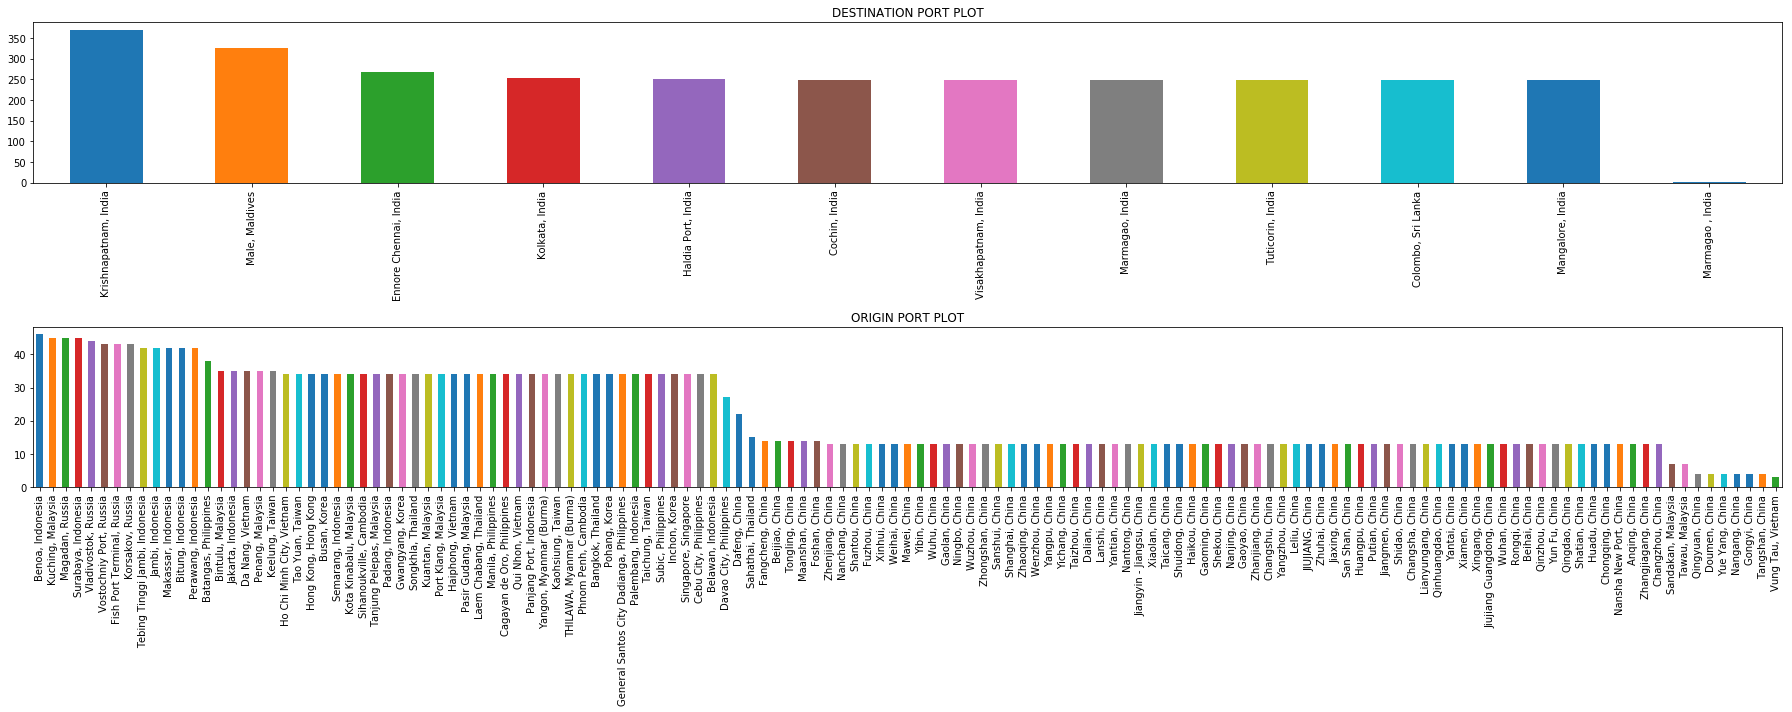

In [107]:
plt.subplot(2,1,1)
plt.title("DESTINATION PORT PLOT")
dest.plot.bar(figsize=(5,10))

plt.subplot(2,1,2)
plt.title("ORIGIN PORT PLOT")
origin.plot.bar(figsize=(25,10))

plt.tight_layout()
plt.show()

In [75]:
xeneta_reshaped.dropna(axis=0, how='all', inplace=True)

In [76]:
 """select subset of data with "FAK" commodity and "CY/CY" service mode"""

xeneta_reshaped = xeneta_reshaped[(xeneta_reshaped['Commodity'] == 'FAK') & (xeneta_reshaped['Service Mode'] == 'CY/CY')]

In [77]:
def get_port_code(df: pd.Series()) -> List[str]:

    """ Connects to xeneta.db and pulls port codes
    INPUT: port_name series
    OUTPUT: port_code array
    """
    code = []
    connection = sqlite3.connect(r"C:\Users\Sammy\Downloads\test\test\xeneta.db", check_same_thread = False) #connect to database
    cursor = connection.cursor()

    for port_name in tqdm(df, desc="looping over port names"):
        try:
            cursor.execute("""SELECT port_code FROM ports WHERE port_name = '{port_name}';""".format(port_name = port_name)) #run query
            val = cursor.fetchone()[0] #select first output
            code.append(val) #append to val to code
        except Exception as ex:
            code.append(np.nan) # NoneType error insert nan
        
    connection.commit()
    cursor.close()
    connection.close()

    return code


In [78]:
xeneta_reshaped['Origin Port (code)'] = get_port_code(xeneta_reshaped['Origin Port (name)']) #call get_port_code and create code column from the 
xeneta_reshaped['Destination Port (code)'] = get_port_code(xeneta_reshaped['Destination Port (name)'])


looping over port names: 100%|██████████| 2952/2952 [00:00<00:00, 8656.85it/s]


In [79]:
xeneta_reshaped.head()

,Origin Port (name),Load Port,Discharge Port,Destination Port (name),Rate - Valid from,Rate - Valid to,Service Mode,Commodity,THC Used,"BAS, Currency",...,"RHI, Currency","RHI, 20DC","RHI, 40DC","RHI, 40HC","SBF, Currency","SBF, 20DC","SBF, 40DC","SBF, 40HC",Origin Port (code),Destination Port (code)
0,"Anqing, China",NaN,NaN,"Cochin, India",29-Apr-2011,12-May-2011,CY/CY,FAK,"DPA,OPA,SBF,BAF",USD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CNAQG,INCOK
12,"Anqing, China",NaN,NaN,"Colombo, Sri Lanka",29-Apr-2011,12-May-2011,CY/CY,FAK,"DPA,OPA,SBF,BAF,DHC",USD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CNAQG,LKCMB
24,"Anqing, China",NaN,NaN,"Ennore Chennai, India",29-Apr-2011,12-May-2011,CY/CY,FAK,"DPA,OPA,SBF,BAF",USD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CNAQG,INMAA
36,"Anqing, China",NaN,NaN,"Haldia Port, India",29-Apr-2011,12-May-2011,CY/CY,FAK,"DPA,OPA,SBF,BAF",USD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CNAQG,INHAL
48,"Anqing, China",NaN,NaN,"Kolkata, India",29-Apr-2011,12-May-2011,CY/CY,FAK,"DPA,OPA,SBF,BAF",USD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CNAQG,INCCU


### Prioritizing values in 'Load Port' and 'Discharge Port' to fill the origin and destination name columns

In [80]:
xeneta_reshaped['Load Port'].value_counts() #chech for values in load port

Arkhangelsk, Russia    43
Name: Load Port, dtype: int64

In [81]:
xeneta_reshaped['Discharge Port'].value_counts() # check for values in Discharge Port

Series([], Name: Discharge Port, dtype: int64)

In [82]:
xeneta_reshaped[xeneta_reshaped['Load Port'] == 'Arkhangelsk, Russia'].head()

,Origin Port (name),Load Port,Discharge Port,Destination Port (name),Rate - Valid from,Rate - Valid to,Service Mode,Commodity,THC Used,"BAS, Currency",...,"RHI, Currency","RHI, 20DC","RHI, 40DC","RHI, 40HC","SBF, Currency","SBF, 20DC","SBF, 40DC","SBF, 40HC",Origin Port (code),Destination Port (code)
2774,"Fish Port Terminal, Russia","Arkhangelsk, Russia",NaN,"Cochin, India",29-Apr-2011,12-May-2011,CY/CY,FAK,"DPA,OPA,SBF,BAF",USD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,RUFPT,INCOK
2775,"Fish Port Terminal, Russia","Arkhangelsk, Russia",NaN,"Cochin, India",29-Apr-2011,12-May-2011,CY/CY,FAK,"DPA,OPA,SBF,BAF",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,RUFPT,INCOK
2779,"Fish Port Terminal, Russia","Arkhangelsk, Russia",NaN,"Cochin, India",29-Apr-2011,12-May-2011,CY/CY,FAK,"DPA,OPA,SBF,BAF",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,RUFPT,INCOK
2784,"Fish Port Terminal, Russia","Arkhangelsk, Russia",NaN,"Cochin, India",29-Apr-2011,12-May-2011,CY/CY,FAK,"DPA,OPA,SBF,BAF",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,RUFPT,INCOK
2785,"Fish Port Terminal, Russia","Arkhangelsk, Russia",NaN,"Colombo, Sri Lanka",29-Apr-2011,12-May-2011,CY/CY,FAK,"DPA,OPA,SBF,BAF,DHC",USD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,RUFPT,LKCMB


In [83]:
xeneta_reshaped['Origin Port (name)'] = xeneta_reshaped['Origin Port (name)'].str.replace('Fish Port Terminal, Russia', 'Arkhangelsk, Russia') #replacing values in Origin Port with those in Load port. It contained the same number of values with these port names in both columns that why it is being replace like this

In [84]:
xeneta_reshaped.drop(['Load Port','Discharge Port'], axis=1,inplace=True) # Drop the unused columns

In [85]:
def THC_used(row: str) -> str:
    """Replaces Used THC with OTHC, DTHC, BOTH or NONE
    INPUT:series
    RETURN: Series with replaced values
    """
    if 'OHC' in row:
        thc = 'OTHC' 
    elif 'DHC' in row:
        thc = 'DTHC'
    elif 'DHC' and 'OHC' in row:
        thc = 'BOTH'
    else:
        thc = 'NONE'

    return thc

xeneta_reshaped['THC Used'] = xeneta_reshaped['THC Used'].apply(THC_used) # apply the function to the column
xeneta_reshaped['THC Used'].value_counts()

NONE    2674
DTHC     244
OTHC      34
Name: THC Used, dtype: int64

In [86]:

"""The assumption is that wherever there is a 0 in the OHC/DHC column The THC used value should be replaced with 'BOTH'"""

xeneta_reshaped.loc[(xeneta_reshaped['OHC, 20DC'] == '0') & (xeneta_reshaped['THC Used'] != ('DTHC' or 'OTHC')), 'THC Used'] = 'BOTH'
xeneta_reshaped.loc[(xeneta_reshaped['DHC, 20DC'] == '0') & (xeneta_reshaped['THC Used'] != ('DTHC' or 'OTHC')), 'THC Used'] = 'BOTH'
xeneta_reshaped['THC Used'].value_counts()


NONE    2664
DTHC     244
OTHC      23
BOTH      21
Name: THC Used, dtype: int64

In [87]:
xeneta_reshaped = xeneta_reshaped.replace('0', np.nan) # replace all zeros with nan

In [88]:
xeneta_reshaped['Customer'] = 'AWESOME CUSTOMER INC.'  #create 3 new columns
xeneta_reshaped['Carrier'] = 'XENETA' 
xeneta_reshaped['Contract Number'] = 'Super Secret Contract'

In [89]:
""" Rearrangin the dataframe columns"""

xeneta_reshaped = xeneta_reshaped[['Rate - Valid from', 'Rate - Valid to', 'Origin Port (name)',
       'Origin Port (code)', 'Destination Port (name)',
       'Destination Port (code)', 'Customer', 'Carrier', 'Contract Number',
       'Commodity', 'THC Used','BAS, Currency','BAS, 20DC', 'BAS, 40DC', 'BAS, 40HC', 'CFD, Currency',
       'CFD, 20DC', 'CFD, 40DC', 'CFD, 40HC', 'CFO, Currency', 'CFO, 20DC',
       'CFO, 40DC', 'CFO, 40HC', 'DHC, Currency', 'DHC, 20DC', 'DHC, 40DC',
       'DHC, 40HC', 'EBS, Currency', 'EBS, 20DC', 'EBS, 40DC', 'EBS, 40HC',
       'ERS, Currency', 'ERS, 20DC', 'ERS, 40DC', 'ERS, 40HC', 'EXP, Currency',
       'EXP, 20DC', 'EXP, 40DC', 'EXP, 40HC', 'IMP, Currency', 'IMP, 20DC',
       'IMP, 40DC', 'IMP, 40HC', 'LSS, Currency', 'LSS, 20DC', 'LSS, 40DC',
       'LSS, 40HC', 'OHC, Currency', 'OHC, 20DC', 'OHC, 40DC', 'OHC, 40HC',
       'PAE, Currency', 'PAE, 20DC', 'PAE, 40DC', 'PAE, 40HC', 'PSS, Currency',
       'PSS, 20DC', 'PSS, 40DC', 'PSS, 40HC', 'RHI, Currency', 'RHI, 20DC',
       'RHI, 40DC', 'RHI, 40HC', 'SBF, Currency', 'SBF, 20DC', 'SBF, 40DC',
       'SBF, 40HC']]

xeneta_reshaped.head()  

,Rate - Valid from,Rate - Valid to,Origin Port (name),Origin Port (code),Destination Port (name),Destination Port (code),Customer,Carrier,Contract Number,Commodity,...,"PSS, 40DC","PSS, 40HC","RHI, Currency","RHI, 20DC","RHI, 40DC","RHI, 40HC","SBF, Currency","SBF, 20DC","SBF, 40DC","SBF, 40HC"
0,29-Apr-2011,12-May-2011,"Anqing, China",CNAQG,"Cochin, India",INCOK,AWESOME CUSTOMER INC.,XENETA,Super Secret Contract,FAK,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,29-Apr-2011,12-May-2011,"Anqing, China",CNAQG,"Colombo, Sri Lanka",LKCMB,AWESOME CUSTOMER INC.,XENETA,Super Secret Contract,FAK,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24,29-Apr-2011,12-May-2011,"Anqing, China",CNAQG,"Ennore Chennai, India",INMAA,AWESOME CUSTOMER INC.,XENETA,Super Secret Contract,FAK,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36,29-Apr-2011,12-May-2011,"Anqing, China",CNAQG,"Haldia Port, India",INHAL,AWESOME CUSTOMER INC.,XENETA,Super Secret Contract,FAK,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
48,29-Apr-2011,12-May-2011,"Anqing, China",CNAQG,"Kolkata, India",INCCU,AWESOME CUSTOMER INC.,XENETA,Super Secret Contract,FAK,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [104]:
#missing values
percentage_missing_values = (xeneta_reshaped.isnull().sum()/len(xeneta_reshaped)) * 100
print('Percentage of values missing from each column: \n\n{percentage_missing_values}'.format(percentage_missing_values = percentage_missing_values))

# #percentage of missing data
all_cells = np.product(xeneta_reshaped.shape)
missing_values = xeneta_reshaped.isnull().sum()
all_missing = missing_values.sum()
percentage_missing = (all_missing/all_cells)*100
print('\n')
print('Percentage of data missing: = {percentage_missing}'.format(percentage_missing = percentage_missing))


Percentage of values missing from each column: 

Rate - Valid from           0.000000
Rate - Valid to             0.000000
Origin Port (name)          0.033875
Origin Port (code)          0.033875
Destination Port (name)     0.000000
Destination Port (code)     0.000000
Customer                    0.000000
Carrier                     0.000000
Contract Number             0.000000
Commodity                   0.000000
THC Used                    0.000000
BAS, Currency              53.048780
BAS, 20DC                  53.048780
BAS, 40DC                  52.743902
BAS, 40HC                  52.743902
DHC, Currency              57.283198
DHC, 20DC                  61.483740
DHC, 40DC                  61.449864
DHC, 40HC                  61.551491
EXP, Currency              55.284553
EXP, 20DC                  55.284553
EXP, 40DC                  54.979675
EXP, 40HC                  54.979675
IMP, Currency              52.811653
IMP, 20DC                  57.012195
IMP, 40DC                 

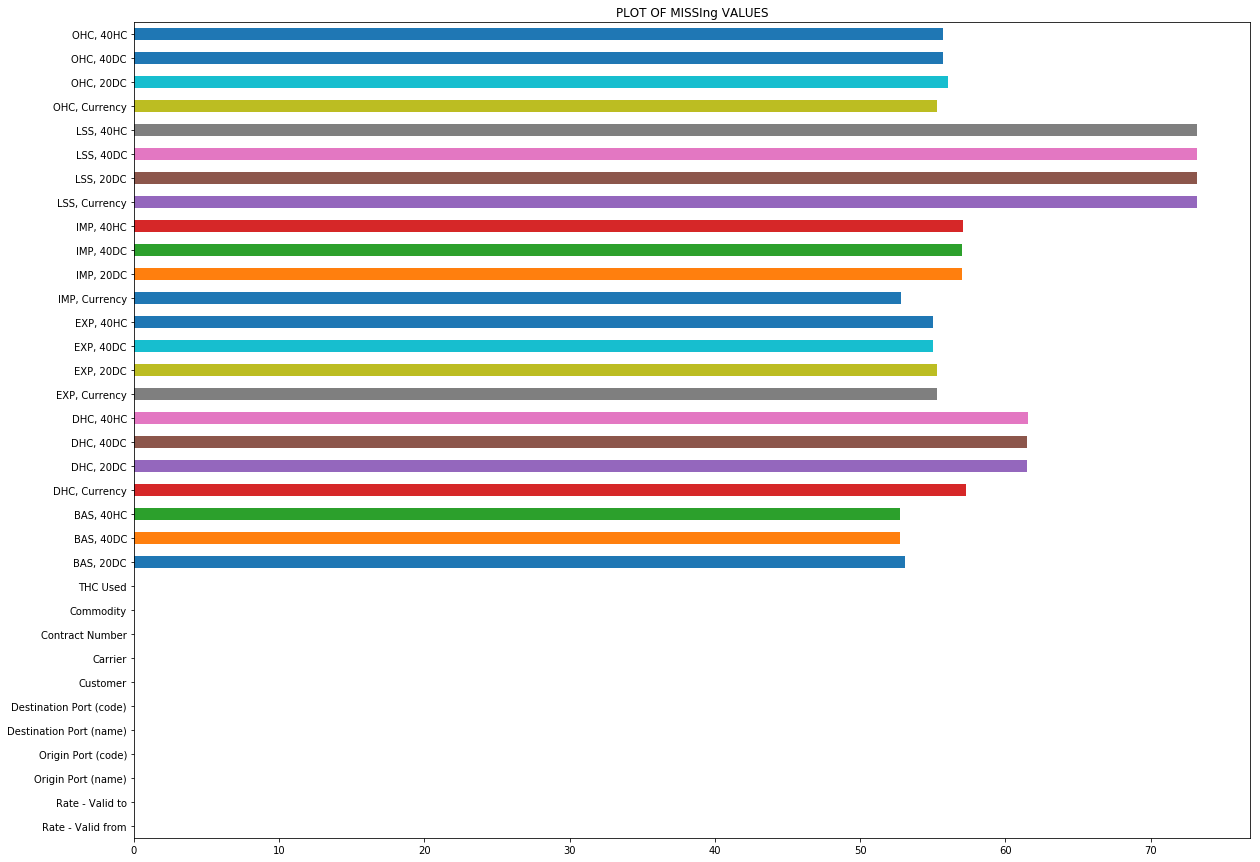

In [91]:
plt.figure()
plt.title("PLOT OF MISSIng VALUES")
missing_values.plot.barh(x="A", y="B", title="", figsize=(20,15))

In [92]:
# xeneta_reshaped[xeneta_reshaped.notnull()]

In [93]:
# Ideally most of these columns should be dropped due to high percentage of missing values
xeneta_reshaped.drop(['EBS, Currency','EBS, 20DC','EBS, 40DC','EBS, 40HC', 'CFD, Currency','CFD, 20DC','CFD, 40DC','CFD, 40HC', 'CFO, Currency','CFO, 20DC','CFO, 40DC','CFO, 40HC','ERS, 20DC','ERS, 40DC','ERS, 40HC', 'ERS, Currency','PAE, 20DC','PAE, 40DC','PAE, 40HC', 'PAE, Currency', 'PSS, 20DC','PSS, 40DC','PSS, 40HC', 'PSS, Currency', 'RHI, 20DC','RHI, 40DC','RHI, 40HC', 'RHI, Currency', 'SBF, 20DC','SBF, 40DC','SBF, 40HC','SBF, Currency' ], axis = 1, inplace=True)

#Interpolating and filling the charges with random values doesn't seem appropriate. That could be done provided there was more information. So these the final dataframe contains some nans 

xeneta_reshaped['Origin Port (name)'].fillna(method="ffill")
xeneta_reshaped['Origin Port (code)'].fillna(method="ffill")

xeneta_reshaped['Destination Port (name)'].fillna(method="ffill",inplace =True)
xeneta_reshaped['Destination Port (code)'].fillna(method="ffill",inplace =True)

In [100]:
# Checking for spelling mistakes and Capitalization
# xeneta_reshaped['Origin Port (name)'].unique()
# xeneta_reshaped['Destination Port (name)'].unique()

In [99]:
# Investigating Port codes = 'Not a port' for a suitable way to replace it
# xeneta_reshaped['Origin Port (code)'].unique()
# xeneta_reshaped.loc[xeneta_reshaped['Origin Port (code)']=="Not a port"] 

In [106]:
# xeneta_reshaped.loc[xeneta_reshaped['Destination Port (code)']=="Not a port"]


In [97]:
xeneta_reshaped.to_excel("ocean freight rates.xlsx", index=False)